In [1]:
import tsp_data_util as tsp_data_util
import tsplib95
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import gc
from pso import pso
from aco import aco
import os

In [2]:
def getData(technique, problem):
    start = time.time()
    
    # runs the  problem with the technique 
    result = technique(problem.edge_weights)
    end = time.time()
    
    # gets the solution
    returned_solution = result['sequence']
    
    #the time 
    runtime = end-start
    
    # memory
    """TODO: Check that memory actually works"""
    #memory = torch.cuda.memory_allocated(0)
    memory = 0
    
    #function evalauations 
    func_evals = result['func_evals']
    
    #used parameters
    params = result['parameters']

    #find proximity to optimal solution
    solution_distance = tsp_data_util.get_tour_length(problem.file, returned_solution)
    approximation_ratio = solution_distance/problem.solution_length

    return {'memory' : memory, 'closeness' : approximation_ratio, 'func_evals' : func_evals, 'runtime' : runtime}

In [3]:
def generatePlots(results):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].scatter(results['memory'], results['closeness'])
    ax[0].set_title('Memory vs. AR')
    ax[0].set_ylabel('Approximation Ratio')
    ax[0].set_xlabel('Memory')
    
    ax[1].scatter(results['func_evals'], results['closeness'])
    ax[1].set_title('Distance Checks vs. AR')
    ax[1].set_ylabel('Approximation Ratio')
    ax[1].set_xlabel('Distance Checks')
    
    ax[2].scatter(results['runtime'], results['closeness'])
    ax[2].set_title('Runtime vs. AR')
    ax[2].set_ylabel('Approximation Ratio')
    ax[2].set_xlabel('Runtime')

    fig.suptitle(results['technique'])
    fig.tight_layout()

In [4]:
def sortedTechnique(e_matrix):
    res = torch.tensor(range(1,e_matrix.shape[0]+1))
    func_evals = 0
    params = {}
    return {'func_evals': func_evals, 'sequence': res, 'parameters':params}

In [5]:
class Problem:
    
    def __init__(self, edge_weights, solution, solution_length, tspfile):
        self.edge_weights = edge_weights
        self.solution = solution
        self.solution_length = solution_length
        self.file = tspfile

In [6]:
def fill_problems(directory, n_problems = None):
    '''Fills a list of problem objects from the directory.
    Not all problems have an optimal tour. All problems DO have an optimal length.
    Regardless of if they have an optimal tour, they are placed in the problems list.
    To compare tours, use the tour length and not the sequence.'''
    problems = []
    #get all the files in the directory
    files = os.listdir(directory)

    #set the n_problems to get
    if n_problems is None or n_problems > len(files): 
        n_problems = len(files)
        
    i = 0
    n = 0
    while n < n_problems and i < len(files):
    #for i in range(n_problems):
        #print(files[i])

        # check if it is a tsp file
        if files[i].endswith('.tsp'):
            #print('tsp file')
            
            tsp_file = os.path.join(directory, files[i])

            weight_matrix = tsp_data_util.generate_edge_weight_matrix(tsp_file)
            opt_solution_tour = []
            opt_solution_length = 0

            
            #opt solution tour will be [] if one does not exist.
            opt_solution_tour = tsp_data_util.get_optimal_tour(tsp_file)
            opt_solution_length = tsp_data_util.get_optimal_tour_length(tsp_file)
            p = Problem(weight_matrix, opt_solution_tour, opt_solution_length, tsp_file)
            problems.append(p)
            n += 1
        i += 1
        #print("next")
    return problems

no solution tour file exists for:  heidelberg_TSP_small/brazil58.tsp  every tsp file has a opt tour length
no solution tour file exists for:  heidelberg_TSP_small/gr21.tsp  every tsp file has a opt tour length
no solution tour file exists for:  heidelberg_TSP_small/gr17.tsp  every tsp file has a opt tour length


no solution tour file exists for:  heidelberg_TSP_small/brazil58.tsp  every tsp file has a opt tour length
no solution tour file exists for:  heidelberg_TSP_small/gr21.tsp  every tsp file has a opt tour length
no solution tour file exists for:  heidelberg_TSP_small/gr17.tsp  every tsp file has a opt tour length


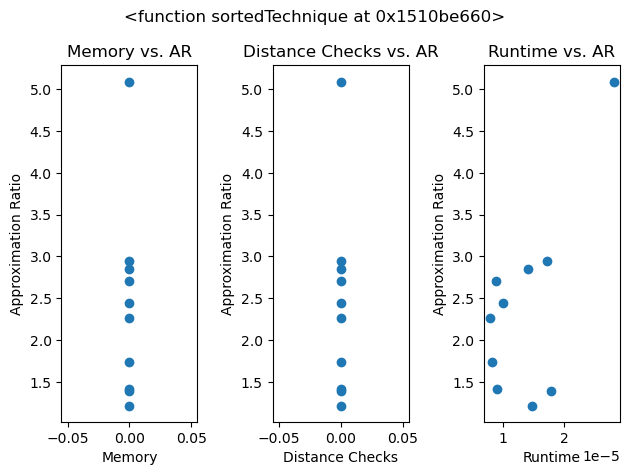

<Figure size 1000x700 with 0 Axes>

In [7]:
#collect techniques in an array
techniques = [sortedTechnique]


#problems = fill_problems(directory)
#problems = [p1,p2]
problems = fill_problems('heidelberg_TSP_small', 10)

# run each function on many problems to compare results
for t in techniques:
    figs = []
    # run each problem on the technique
    results = {'memory' : [], 'runtime': [], 'func_evals': [], 'closeness': []}
    for p in problems:
        #take data and add to list for plotting purposes
        r = getData(t,p)
        results['memory'].append(r['memory'])
        results['func_evals'].append(r['func_evals'])
        results['runtime'].append(r['runtime'])
        results['closeness'].append(r['closeness'])
        
    #for each function, generate a subfigure with each plot
    results['technique'] = t
    figs.append(generatePlots(results))

fig = plt.figure(figsize=(10, 7))
(figs[0]) = fig.subfigures(3, 1)
plt.show()

In [8]:
optimal_tour_distance = tsp_data_util.optimal_tour_distance
tsp_file = 'heidelberg_TSP_data/ch150.tsp'  # coord matrix

weight_matrix = tsp_data_util.generate_edge_weight_matrix(tsp_file)
print("Edge Weight Matrix:")
print(weight_matrix)

opt_solution_tour = tsp_data_util.get_optimal_tour(tsp_file)
print(opt_solution_tour)

opt_solution_length = tsp_data_util.get_tour_length(tsp_file, opt_solution_tour)
print(opt_solution_length)

p1 = Problem(weight_matrix, opt_solution_tour, opt_solution_length, tsp_file)


tsp_file = 'heidelberg_TSP_data/a280.tsp'  # coord matrix
weight_matrix = tsp_data_util.generate_edge_weight_matrix(tsp_file)
opt_solution_tour = tsp_data_util.get_optimal_tour(tsp_file)
opt_solution_length = tsp_data_util.get_tour_length(tsp_file, opt_solution_tour)

p2 = Problem(weight_matrix, opt_solution_tour, opt_solution_length, tsp_file)

Edge Weight Matrix:
tensor([[  0., 577., 188.,  ..., 770., 270., 379.],
        [577.,   0., 591.,  ..., 368., 607., 615.],
        [188., 591.,   0.,  ..., 688.,  83., 194.],
        ...,
        [770., 368., 688.,  ...,   0., 657., 600.],
        [270., 607.,  83.,  ..., 657.,   0., 113.],
        [379., 615., 194.,  ..., 600., 113.,   0.]])
tensor([  1,  98, 103,  82,  95, 107,   5, 100, 143,  97, 146,  26,  75,  18,
        142,  85,  65, 132, 137,  50,  55,  58, 141,  83,  56,  90,  46,  92,
         54, 138, 134, 131,  32,  23,  38,  67,  43, 109,  51,  20,  25, 110,
         81,  29,  86, 135,  70, 108, 102, 114,  99,  19,   2,  37,   6,  28,
          9,  42, 120,  47, 139,  40,  53, 118,  24,  12, 116, 101,  41,  57,
         39, 127,  69,  36,  61,  11, 148, 130,  17,  66,  60, 140, 117, 129,
         27,  31, 123,  74,  13, 106,  91, 119,  68, 128,  45,  71,  44,  64,
        112, 136, 145, 144,  49, 147,  72,  80,  14, 122,  77, 133,  15,  78,
         21, 150, 115,   4, 10

Issues with optimization functions:

PSO: tensor path contains non-integer values
ACO: computations use np array instead of tensors
TABU: Returns list of cities, not dictionary with tensors